# Imports and constants

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, accuracy_score

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression

from classifiers.utils.feature_extractors import ColorHistogramTransformer, HuMomentsTransformer, \
    HaralickFeaturesTransformer

from classifiers.utils.load_balanced_data import load_balanced_data_pipeline

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Load and preprocess data

In [2]:
metadata_path = "HAM10000_metadata.csv"
image_dir = "HAM10000_images_part_1"

augmented_images, augmented_labels = load_balanced_data_pipeline(metadata_path, image_dir)

Loading balanced data...
Metadata loaded.
Generating image ID list...
Image ID list generated.
Loading images for augmentation...
Augmenting images...
Images augmented.
Data loading complete.


# Train/test split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(augmented_images, augmented_labels, test_size=0.2, random_state=42)

y_train_1d = np.argmax(y_train, axis=1)
y_test_1d = np.argmax(y_test, axis=1)

# Feature extraction and LogReg pipeline

In [13]:
feature_union = FeatureUnion([
    ("color_histogram", ColorHistogramTransformer()),
    ("hu_moments", HuMomentsTransformer()),
    ("haralick_features", HaralickFeaturesTransformer())
])

scaler = StandardScaler()

pipeline = Pipeline([
    ("features", feature_union),
    ("scaler", scaler),
    ("classifier", LogisticRegression(max_iter=5000))
])

param_grid = {
    "classifier__C": [200],
    'classifier__penalty': ['l1', 'l2', 'elasticnet'],
    'classifier__solver': ['saga'],  # 'saga' supports 'l1', 'l2', 'elasticnet'
    'classifier__tol': [1e-4, 1e-3],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train_1d)

# Predict the labels for the test using LogReg
y_pred = grid_search.predict(X_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Library/Python/3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Python/3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Python/3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Python/3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Python/3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Python/3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  w

# Classification report

In [14]:
# Evaluate the LogReg classifier
print("Classification report for LogReg classifier")
print(classification_report(y_test_1d, y_pred))
print("Accuracy: ", accuracy_score(y_test_1d, y_pred))
print("Best params: ", grid_search.best_params_)

Classification report for LogReg classifier
              precision    recall  f1-score   support

           0       0.41      0.59      0.49        32
           1       0.36      0.38      0.37        40
           2       0.41      0.57      0.48        35
           3       0.61      0.52      0.56        42
           4       0.62      0.42      0.50        43
           5       0.78      0.69      0.73        42
           6       0.88      0.78      0.83        46

    accuracy                           0.57       280
   macro avg       0.58      0.57      0.57       280
weighted avg       0.60      0.57      0.57       280

Accuracy:  0.5678571428571428
Best params:  {'classifier__C': 200, 'classifier__penalty': 'l1', 'classifier__solver': 'saga', 'classifier__tol': 0.0001}


# Confusion matrix

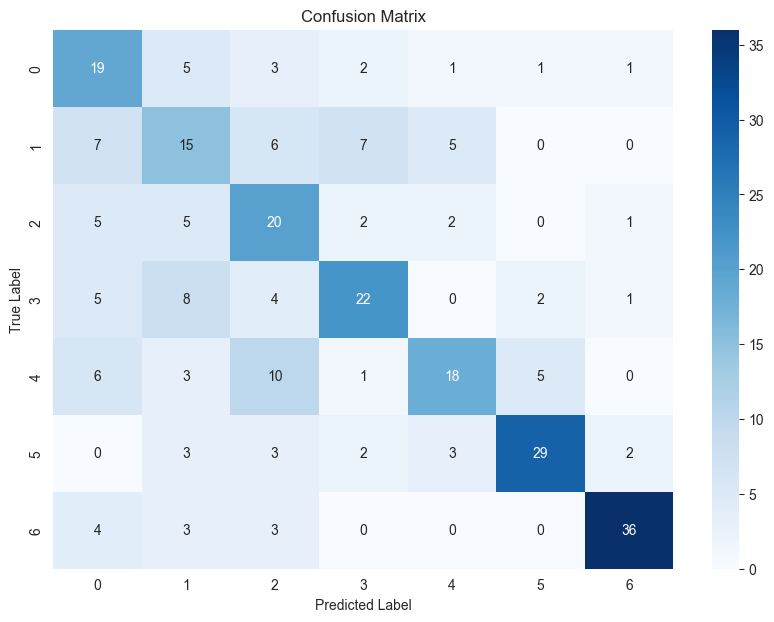

In [15]:
# Confusion matrix
cm = confusion_matrix(y_test_1d, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test_1d), yticklabels=np.unique(y_test_1d))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC curve and AUC

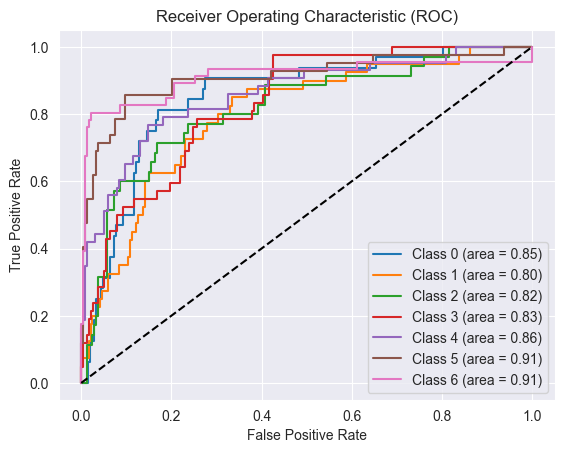

Total AUC: 0.86


In [21]:
y_score = grid_search.predict_proba(X_test)
fpr = {}
tpr = {}
roc_auc = {}

for i in range(y_train.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], y_score[:, i])

# Plot the ROC curve for each class
plt.figure()
for i in range(y_train.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Calculate the total AUC
total_auc = roc_auc_score(y_test, y_score, average='micro')
print(f'Total AUC: {total_auc:.2f}')

# Precision-recall curve

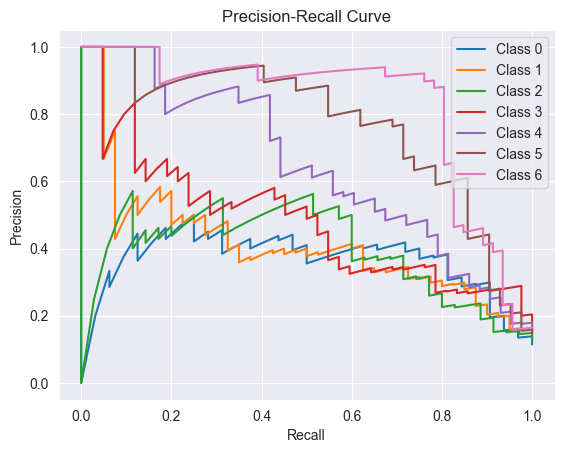

In [17]:
# Compute precision-recall curve for each class
precision = {}
recall = {}
for i in range(y_train.shape[1]):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])

# Plot Precision-Recall curve for each class
plt.figure()
for i in range(y_train.shape[1]):
    plt.plot(recall[i], precision[i], label=f'Class {i}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# Save the model

In [19]:
import joblib

job_file = "log_reg_classifier.pkl"
joblib.dump(grid_search, job_file)

['log_reg_classifier.pkl']